In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_oscillation, sim_synaptic_current
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectra
from fooof.sim.gen import gen_aperiodic

### Translate the aperiodic component

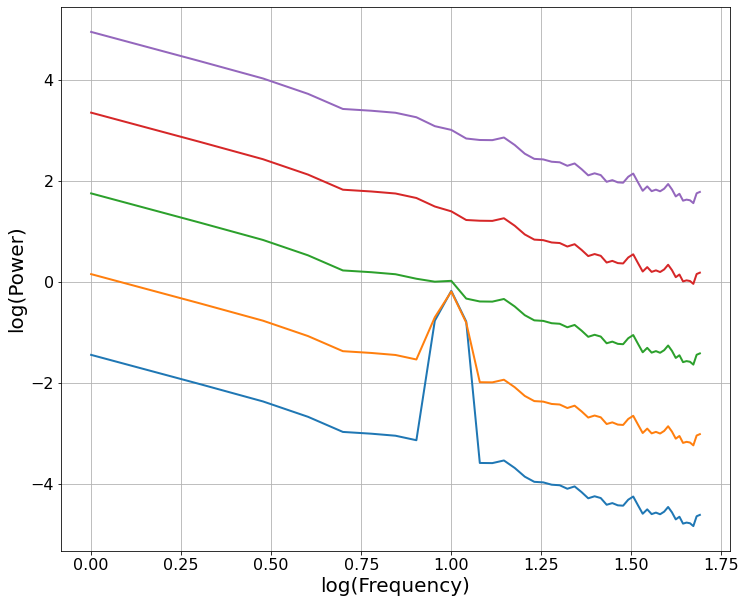

In [2]:
np.random.seed(0)

fig, axes = plt.subplots(figsize=(12, 10))

n_seconds = 20
fs = 500

pl = sim_powerlaw(n_seconds, fs, exponent=-2)
osc = sim_oscillation(n_seconds, fs, 10)

times = np.arange(0, n_seconds, 1/fs)
namps = 10 ** np.arange(0, 4, .8)
powers = np.zeros((len(namps), 49))

for idx, namp in enumerate(namps):
     
    sig = osc + pl * namp
    
    freqs, powers_tmp = compute_spectrum(sig, fs)
    freqs = freqs[1:50]
    powers[idx] = powers_tmp[1:50]
    
    plot_spectrum(freqs, powers[idx], ax=axes, log_freqs=True, log_powers=True)

### For the three largest aperiodic translations, oscillations aren't detected by fooof.

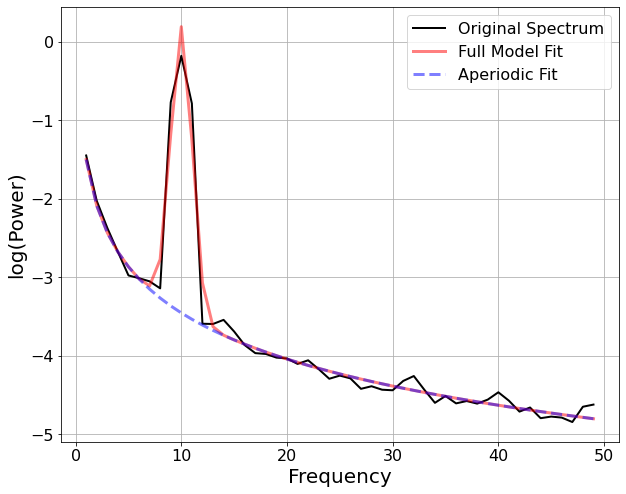

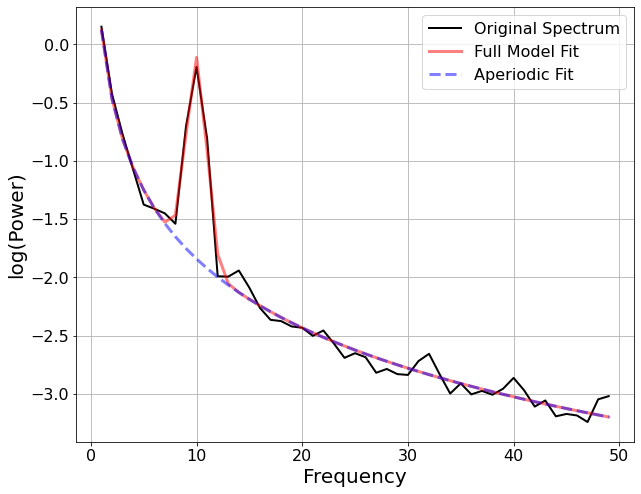

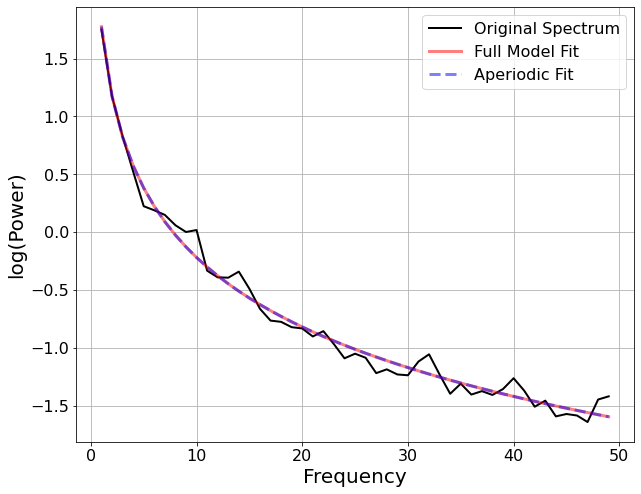

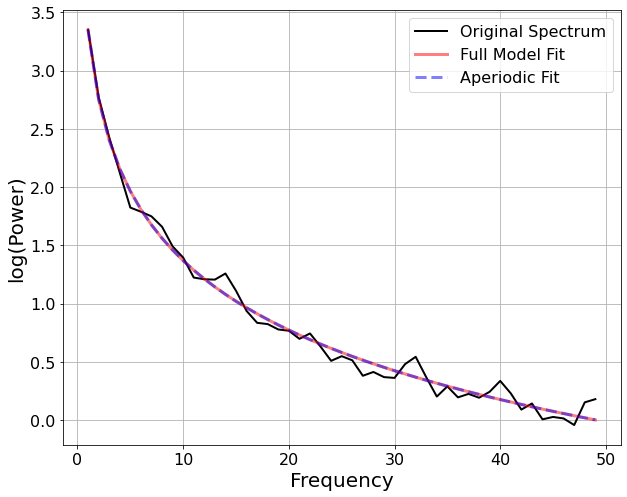

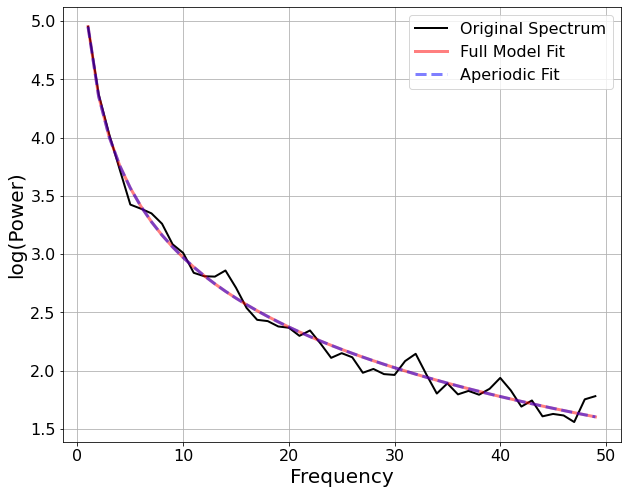

In [3]:
fg = FOOOFGroup(min_peak_height=.5, verbose=False)
fg.fit(freqs, powers)
for idx in range(len(fg)):
    fg.get_fooof(idx).plot()

### Remove the aperiodic fits from spectra in linear space. The plots are the flatten spectra, which are inputs to the iterative gaussian fitting procedure. Something is wrong here.

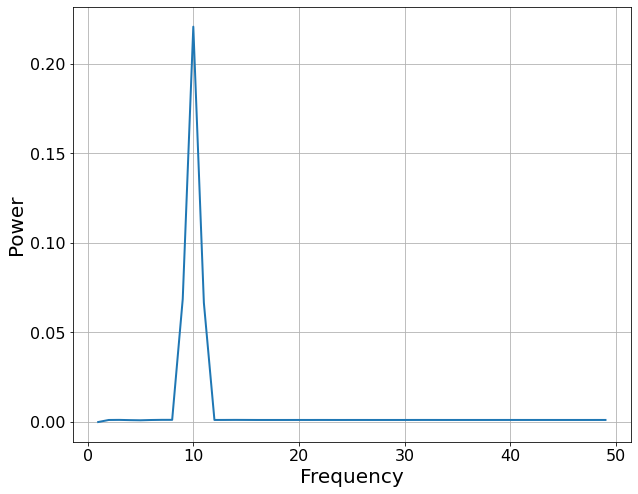

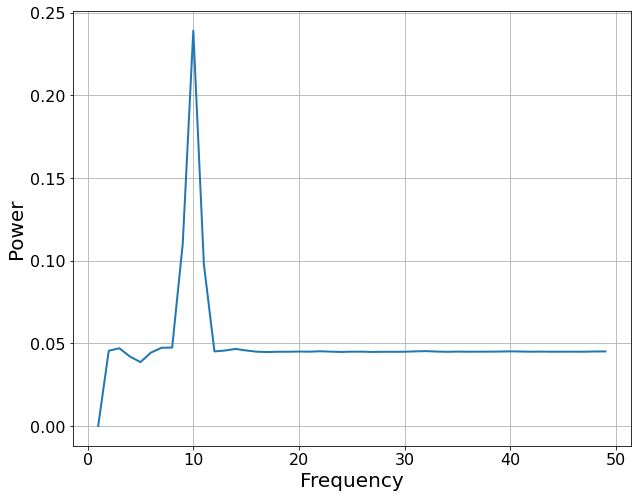

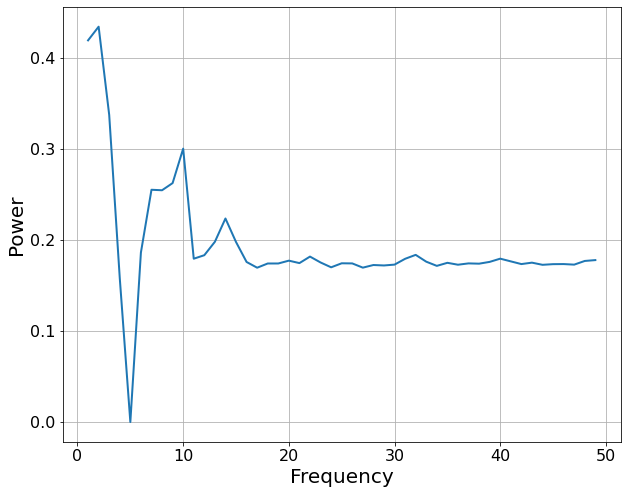

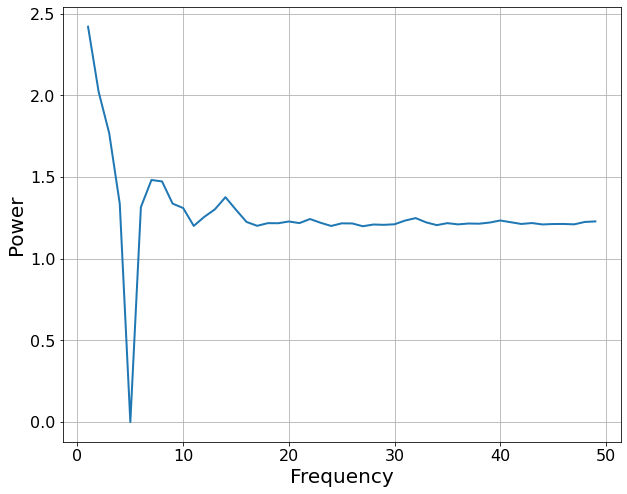

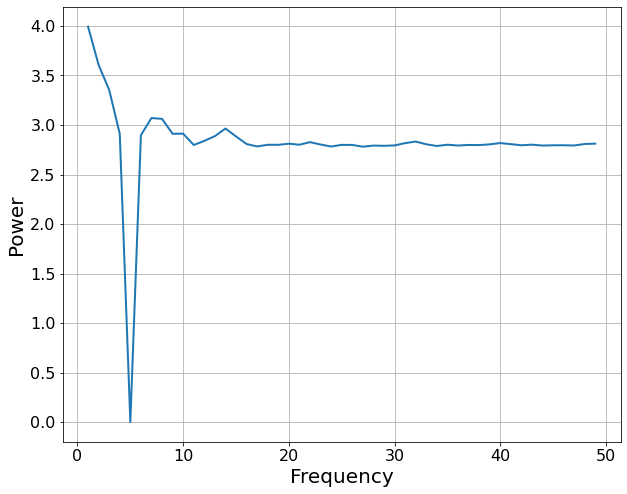

In [4]:
for idx in range(len(fg)):

    fm = fg.get_fooof(idx)

    # Get the aperiodic fit
    aperiodic_params_ = fm._robust_ap_fit(fm.freqs, fm.power_spectrum)
    _ap_fit = gen_aperiodic(fm.freqs, aperiodic_params_)
    
    # Remove the aperiodic fit in linear space
    _spectrum_flat = 10**fm.power_spectrum - 10**_ap_fit
    
    # Shift the spectrum to ensure all values are positive, required for logging
    _spectrum_flat = _spectrum_flat + np.abs(np.min(_spectrum_flat)) + 1

    # Move the flatten spectrum back into log space
    _spectrum_flat = np.log10(_spectrum_flat)

    plot_spectrum(freqs, _spectrum_flat)